In [1]:
import os, getpass
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

def check_tyre_wear(lap_number: int) -> str:
    """Checks the estimated tyre wear based on the current lap number."""
    if lap_number < 15:
        return f"Lap {lap_number}: Tyre wear is low. Estimated 85% life remaining."
    elif lap_number < 30:
        return f"Lap {lap_number}: Tyre wear is medium. Estimated 50% life remaining."
    else:
        return f"Lap {lap_number}: Tyre wear is high. Estimated 20% life remaining. Consider pitting."

def get_weather_forecast(sector: int) -> str:
    """Gets the weather forecast for a specific sector of the track."""
    if sector == 1:
        return f"Sector {sector}: Forecast is clear, track temperature stable."
    elif sector == 2:
        return f"Sector {sector}: Slight chance of light drizzle in the next 10 laps."
    else:
        return f"Sector {sector}: Track remains dry for now."

def suggest_pit_strategy(current_lap: int, laps_remaining: int) -> str:
    """Suggests a pit stop strategy based on current lap and laps remaining."""
    optimal_pit_window_start = 20
    optimal_pit_window_end = 35
    if optimal_pit_window_start <= current_lap <= optimal_pit_window_end:
        return f"Lap {current_lap}/{laps_remaining} laps remaining: Currently within the optimal pit window. Evaluate traffic."
    elif current_lap < optimal_pit_window_start:
        return f"Lap {current_lap}/{laps_remaining} laps remaining: Too early for optimal one-stop. Hold position."
    else:
        return f"Lap {current_lap}/{laps_remaining} laps remaining: Past optimal window. Consider Plan B if tyres degrade rapidly."

tools = [check_tyre_wear, get_weather_forecast, suggest_pit_strategy]
llm = ChatOpenAI(model="gpt-4.1-nano")
llm_with_tools = llm.bind_tools(tools)

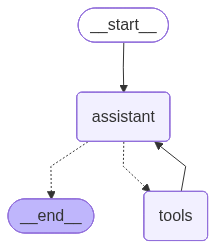

In [3]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

sys_msg = SystemMessage(content="You are a helpful F1 race engineer providing concise updates and strategy advice to the driver based on available tools.")

def race_engineer_assistant(state: MessagesState):
   """Invokes the LLM with the current message state and system prompt."""
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", race_engineer_assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
initial_input = {"messages": [HumanMessage(content="Check tyre wear for lap 25.")]}

thread = {"configurable": {"thread_id": "f1_timetravel_1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Check tyre wear for lap 25.
================================== Ai Message ==================================
Tool Calls:
  check_tyre_wear (call_BXLB0qFuytZF2uqUDa36EhTy)
 Call ID: call_BXLB0qFuytZF2uqUDa36EhTy
  Args:
    lap_number: 25
================================= Tool Message =================================
Name: check_tyre_wear

Lap 25: Tyre wear is medium. Estimated 50% life remaining.
================================== Ai Message ==================================

Tyre wear is medium with approximately 50% of the tyre life remaining at lap 25. Would you like a strategy suggestion based on this information?


In [5]:
graph.get_state({'configurable': {'thread_id': 'f1_timetravel_1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Check tyre wear for lap 25.', additional_kwargs={}, response_metadata={}, id='5824e11a-aa59-4ada-b411-ffb0d160c5cd'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 148, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CTheJE1wgrBgnEtrVLPVOlNpOS82I', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--35f6e85b-ffa6-4655-b77f-6c1daa4a76a9-0', tool_calls=[{'name': 'check_tyre_wear', 'args': {'lap_number': 25}, 'id': 'call_BXLB0qFuytZF2uqUDa36EhTy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 148, 'out

In [6]:
all_states = [s for s in graph.get_state_history(thread)]

In [7]:
len(all_states)

5

In [8]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Check tyre wear for lap 25.', additional_kwargs={}, response_metadata={}, id='5824e11a-aa59-4ada-b411-ffb0d160c5cd')]}, next=('assistant',), config={'configurable': {'thread_id': 'f1_timetravel_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0afcc8-2a68-6d44-8000-433a46f2251e'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-23T04:55:34.862773+00:00', parent_config={'configurable': {'thread_id': 'f1_timetravel_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0afcc8-2a67-698a-bfff-f6a3abf03cb1'}}, tasks=(PregelTask(id='ce14305d-1238-da52-5e1a-f08f4cfda2e3', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 148, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0,

In [9]:
to_replay = all_states[-2]

In [10]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Check tyre wear for lap 25.', additional_kwargs={}, response_metadata={}, id='5824e11a-aa59-4ada-b411-ffb0d160c5cd')]}, next=('assistant',), config={'configurable': {'thread_id': 'f1_timetravel_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0afcc8-2a68-6d44-8000-433a46f2251e'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-23T04:55:34.862773+00:00', parent_config={'configurable': {'thread_id': 'f1_timetravel_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0afcc8-2a67-698a-bfff-f6a3abf03cb1'}}, tasks=(PregelTask(id='ce14305d-1238-da52-5e1a-f08f4cfda2e3', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 148, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0,

In [11]:
to_replay.values

{'messages': [HumanMessage(content='Check tyre wear for lap 25.', additional_kwargs={}, response_metadata={}, id='5824e11a-aa59-4ada-b411-ffb0d160c5cd')]}

In [12]:
to_replay.next

('assistant',)

In [13]:
to_replay.config

{'configurable': {'thread_id': 'f1_timetravel_1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0afcc8-2a68-6d44-8000-433a46f2251e'}}

In [14]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
     if "messages" in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Check tyre wear for lap 25.
================================== Ai Message ==================================
Tool Calls:
  check_tyre_wear (call_gu7uvHAaqBW1O6TRfba2RsRE)
 Call ID: call_gu7uvHAaqBW1O6TRfba2RsRE
  Args:
    lap_number: 25
================================= Tool Message =================================
Name: check_tyre_wear

Lap 25: Tyre wear is medium. Estimated 50% life remaining.
================================== Ai Message ==================================

The tyres are at medium wear with about 50% life remaining. Would you like a strategy suggestion or more info on the weather?


In [15]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Check tyre wear for lap 25.', additional_kwargs={}, response_metadata={}, id='5824e11a-aa59-4ada-b411-ffb0d160c5cd')]

In [16]:
to_fork.config

{'configurable': {'thread_id': 'f1_timetravel_1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0afcc8-2a68-6d44-8000-433a46f2251e'}}

In [17]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Check tyre wear for lap 10 instead.',
                               id=to_fork.values["messages"][0].id)]},
)

In [18]:
fork_config

{'configurable': {'thread_id': 'f1_timetravel_1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0afcc8-5beb-69a2-8001-8d89512dafeb'}}

In [19]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Check tyre wear for lap 10 instead.', additional_kwargs={}, response_metadata={}, id='5824e11a-aa59-4ada-b411-ffb0d160c5cd'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 148, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CTheJE1wgrBgnEtrVLPVOlNpOS82I', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--35f6e85b-ffa6-4655-b77f-6c1daa4a76a9-0', tool_calls=[{'name': 'check_tyre_wear', 'args': {'lap_number': 25}, 'id': 'call_BXLB0qFuytZF2uqUDa36EhTy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 148, 'output_tokens': 18, 'total_t

In [20]:
graph.get_state({'configurable': {'thread_id': 'f1_timetravel_1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Check tyre wear for lap 10 instead.', additional_kwargs={}, response_metadata={}, id='5824e11a-aa59-4ada-b411-ffb0d160c5cd'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 148, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CTheJE1wgrBgnEtrVLPVOlNpOS82I', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--35f6e85b-ffa6-4655-b77f-6c1daa4a76a9-0', tool_calls=[{'name': 'check_tyre_wear', 'args': {'lap_number': 25}, 'id': 'call_BXLB0qFuytZF2uqUDa36EhTy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1

In [21]:
for event in graph.stream(None, fork_config, stream_mode="values"):
     if "messages" in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  check_tyre_wear (call_BXLB0qFuytZF2uqUDa36EhTy)
 Call ID: call_BXLB0qFuytZF2uqUDa36EhTy
  Args:
    lap_number: 25
================================= Tool Message =================================
Name: check_tyre_wear

Lap 25: Tyre wear is medium. Estimated 50% life remaining.
================================== Ai Message ==================================

I will check the tyre wear for lap 10 now.
Tool Calls:
  check_tyre_wear (call_PxyfVvpFlLNRAmBj0DcH3StW)
 Call ID: call_PxyfVvpFlLNRAmBj0DcH3StW
  Args:
    lap_number: 10
================================= Tool Message =================================
Name: check_tyre_wear

Lap 10: Tyre wear is low. Estimated 85% life remaining.
================================== Ai Message ==================================

Tyre wear at lap 10 was low with approximately 85% tyre life remaining. If you need any strategic advice based on this information,

In [22]:
graph.get_state({'configurable': {'thread_id': 'f1_timetravel_1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Check tyre wear for lap 10 instead.', additional_kwargs={}, response_metadata={}, id='5824e11a-aa59-4ada-b411-ffb0d160c5cd'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 148, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CTheJE1wgrBgnEtrVLPVOlNpOS82I', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--35f6e85b-ffa6-4655-b77f-6c1daa4a76a9-0', tool_calls=[{'name': 'check_tyre_wear', 'args': {'lap_number': 25}, 'id': 'call_BXLB0qFuytZF2uqUDa36EhTy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1

In [23]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [24]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [25]:
initial_input = {"messages": [HumanMessage(content="What's the weather forecast for sector 2?")]}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "f1_race_data",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 16, 'prompt_tokens': 149, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CTheSpFwAC6UVLO4y5Od7MGsEFB4N', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--2323dc81-d799-45a9-a8f6-4c3bb2245c70-0', 'tool_calls': [{'name': 'get_weather_forecast', 'args': {'sector': 2}, 'id': 'call_lH6GZDKff2boB293pTBD9zBe', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 149, 'output_tokens': 16, 'total_tokens': 165, 'input_token_details': {'

In [26]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': "What's the weather forecast for sector 2?",
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'af41acc3-e55a-4322-ad77-5b8b98b54704'}]},
 'next': ['assistant'],
 'tasks': [{'id': '07a3ae9c-2c3e-7fc1-a4f6-e8733020ca7f',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 16,
        'prompt_tokens': 149,
        'total_tokens': 165,
        'completion_tokens_details': {'accepted_prediction_tokens': 0,
         'audio_tokens': 0,
         'reasoning_tokens': 0,
         'rejected_prediction_tokens': 0},
        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
       'model_provider': 'openai',
       'model_name': 'gpt-4o-2024-08-0

In [27]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="f1_race_data",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a0f6c-4852-72f8-9e38-1242aa2effbf', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': "What's the weather forecast for sector 2?", 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'af41acc3-e55a-4322-ad77-5b8b98b54704'}]}



Receiving new event of type: values...
{'messages': [{'content': "What's the weather forecast for sector 2?", 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'af41acc3-e55a-4322-ad77-5b8b98b54704'}, {'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 16, 'prompt_tokens': 149, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': '

In [28]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="f1_race_data",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 16, 'prompt_tokens': 149, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CTheXSR1Fn8XClHtziYTcZiPBd87Y', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--e81542cf-8090-4ed9-adab-1dc5935f2b55-0', 'tool_calls': [{'name': 'get_weather_forecast', 'args': {'sector': 2}, 'id': 'call_cl5zybZrbwkIf2kPaUMCnDHO', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 149, 'output_tokens': 16, 'total_tokens': 165, 'input_token_details': {'

In [29]:
initial_input = {"messages": [HumanMessage(content="Strategy check: lap 20, 35 laps left.")]}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="f1_race_data",
    input=initial_input,
    stream_mode="updates",
):
     if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 58, 'prompt_tokens': 152, 'total_tokens': 210, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CTheaxHT6AZUf1fWIW0dZfd6g8GB5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--1843d7d8-be47-4993-8cb6-5807c0d059dc-0', 'tool_calls': [{'name': 'suggest_pit_strategy', 'args': {'current_lap': 20, 'laps_remaining': 35}, 'id': 'call_sKQjecAdYf14ulJp6OcMSkxU', 'type': 'tool_call'}, {'name': 'check_tyre_wear', 'args': {'lap_number': 20}, 'id': 'call_OxCmDWe40BHlU61nThK7r7r5', 'type': 'to

In [30]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Strategy check: lap 20, 35 laps left.',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '33661613-564b-4d0a-9086-7d0912f02fe4'}]}

In [31]:
to_fork['values']['messages'][0]['id']

'33661613-564b-4d0a-9086-7d0912f02fe4'

In [32]:
to_fork['next']

['assistant']

In [33]:
to_fork['checkpoint_id']

'1f0afcc8-d01f-6c1a-8000-114036ed4152'

In [34]:
forked_input = {"messages": HumanMessage(content="Strategy check: lap 30, 25 laps left.",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [35]:
forked_config

{'checkpoint': {'thread_id': '4fde6b42-ff65-486a-b925-22ebb195c725',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0afcc8-e756-6e1a-8001-18f37e3ff581'},
 'configurable': {'thread_id': '4fde6b42-ff65-486a-b925-22ebb195c725',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0afcc8-e756-6e1a-8001-18f37e3ff581'},
 'checkpoint_id': '1f0afcc8-e756-6e1a-8001-18f37e3ff581'}

In [36]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Strategy check: lap 30, 25 laps left.',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '33661613-564b-4d0a-9086-7d0912f02fe4'},
   {'content': '',
    'additional_kwargs': {'refusal': None},
    'response_metadata': {'token_usage': {'completion_tokens': 58,
      'prompt_tokens': 152,
      'total_tokens': 210,
      'completion_tokens_details': {'accepted_prediction_tokens': 0,
       'audio_tokens': 0,
       'reasoning_tokens': 0,
       'rejected_prediction_tokens': 0},
      'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
     'model_provider': 'openai',
     'model_name': 'gpt-4o-2024-08-06',
     'system_fingerprint': 'fp_cbf1785567',
     'id': 'chatcmpl-CTheaxHT6AZUf1fWIW0dZfd6g8GB5',
     'service_tier': 'default',
     'finish_reason': 'tool_calls',
     'logprobs': None},
    'type': 'ai',
    'name': None,
    'id': 'lc_run--1843d7d8-be47-4993-8cb6-5807c0d05

In [37]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="f1_race_data",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
     if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Tools Node--------------------
{'content': 'Lap 20: Tyre wear is medium. Estimated 50% life remaining.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'check_tyre_wear', 'id': '0fba1466-90ec-4c73-a90f-7d6d5f032389', 'tool_call_id': 'call_OxCmDWe40BHlU61nThK7r7r5', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': "We're currently within the optimal pit window. Traffic conditions should be evaluated for a strategic pit stop. Tyre wear is at a medium level, with about 50% life remaining.", 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 37, 'prompt_tokens': 258, 'total_tokens': 295, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2